In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [5]:
EXPERIMENT_BASE_DIR = '/media/big-ssd/experiments'
EXPERIMENT_NAME = 'P3856'
EXPERIMENT_DIR = '{}/{}'.format(EXPERIMENT_BASE_DIR, EXPERIMENT_NAME)
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'

In [6]:
d = pd.read_pickle('{}/identifications-pasef/exp-{}-identifications-pasef-recalibrated.pkl'.format(EXPERIMENT_DIR, EXPERIMENT_NAME))
idents_df = d['identifications_df']

In [7]:
idents_df = idents_df[idents_df['percolator q-value'] < 0.01]

In [25]:
idents_df.columns

Index(['monoisotopic_mz', 'charge', 'monoisotopic_mass', 'feature_intensity',
       'envelope_mono_peak_mz', 'envelope_mono_peak_intensity', 'envelope',
       'isotope_count', 'deconvolution_score', 'scan_apex', 'scan_lower',
       'scan_upper', 'rt_apex', 'rt_lower', 'rt_upper',
       'mono_mz_without_saturated_points', 'mono_intensity_from_raw_points',
       'mono_intensity_adjustment_outcome',
       'isotopic_peak_intensities_from_raw_points', 'precursor_cuboid_id',
       'fragment_ions_l', 'feature_id', 'run_name', 'predicted_mass_error',
       'recalibrated_monoisotopic_mass', 'recalibrated_monoisotopic_mz',
       'file_idx', 'spectrum precursor m/z', 'spectrum neutral mass',
       'peptide mass', 'percolator score', 'percolator q-value',
       'percolator PEP', 'total matches/spectrum', 'sequence', 'protein id',
       'flanking aa', 'observed_monoisotopic_mass', 'theoretical_peptide_mass',
       'mass_accuracy_ppm', 'mass_error'],
      dtype='object')

In [8]:
idents_df.mono_intensity_adjustment_outcome.value_counts(normalize=True) * 100

monoisotopic_not_saturated         94.371562
monoisotopic_saturated_adjusted     5.572013
no_nonsaturated_isotopes            0.056425
Name: mono_intensity_adjustment_outcome, dtype: float64

In [9]:
# find the precursor id of an ident that has high intensity but was not in saturation
idents_df = idents_df.sort_values(by=['feature_intensity'], ascending=False, inplace=False)
idents_df[(idents_df.mono_intensity_adjustment_outcome == 'monoisotopic_not_saturated')].head(5).precursor_cuboid_id

71181    39942
73610    41148
47779    28174
69780    39218
58629    33641
Name: precursor_cuboid_id, dtype: int64

In [10]:
idents_df[(idents_df.mono_intensity_adjustment_outcome == 'monoisotopic_not_saturated')].tail(5).precursor_cuboid_id

9631      8155
67431    38065
90675    51422
248        436
91009    51742
Name: precursor_cuboid_id, dtype: int64

In [11]:
idents_df[(idents_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted') & (idents_df.isotope_count > 4)].head(5).precursor_cuboid_id

80618    44912
79722    44434
75328    42014
80501    44857
71183    39943
Name: precursor_cuboid_id, dtype: int64

In [16]:
selected_sequence = idents_df.loc[80618]

In [17]:
isotope_intensities_df = pd.DataFrame(selected_sequence.isotopic_peak_intensities_from_raw_points)

In [18]:
isotope_intensities_df

,mz,mz_lower,mz_upper,intensity,saturated,inferred_intensity,inferred
0,1114.110540,1114.075056,1114.146023,1927771,True,2555402,True
1,1114.611983,1114.576484,1114.647483,2230750,True,3076655,True
2,1115.113107,1115.077592,1115.148623,1657008,True,2001003,True
3,1115.613851,1115.578319,1115.649383,873721,True,921613,True
4,1116.111671,1116.076123,1116.147218,333976,False,333976,False


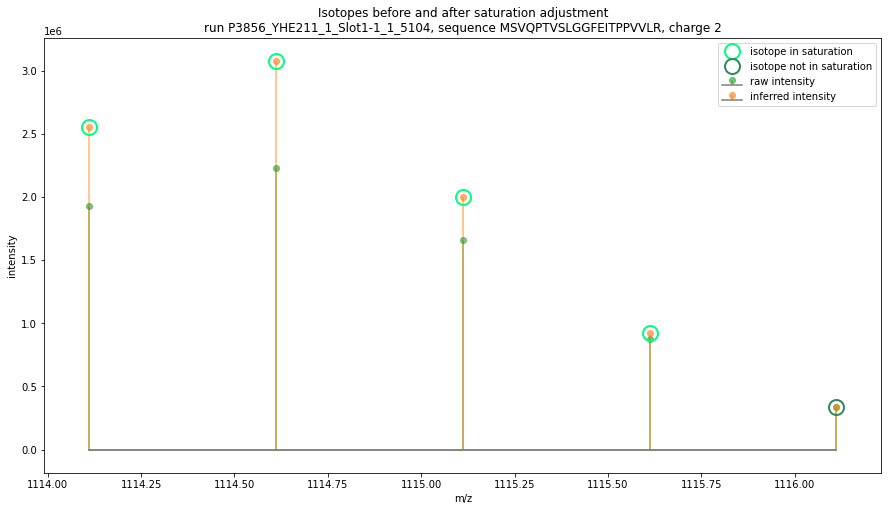

In [19]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(isotope_intensities_df.mz, isotope_intensities_df.intensity, use_line_collection=True, label='raw intensity')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

markerline, stemlines, baseline = ax.stem(isotope_intensities_df.mz, isotope_intensities_df.inferred_intensity, use_line_collection=True, label='inferred intensity')
plt.setp(markerline, 'color', 'tab:orange')
plt.setp(stemlines, 'color', 'tab:orange')
plt.setp(baseline, 'color', colors[7])
plt.setp(markerline, 'alpha', 0.6)
plt.setp(stemlines, 'alpha', 0.6)

# highlight the isotopes with inferred intensity
adjusted_intensity_df = isotope_intensities_df[(isotope_intensities_df.inferred == True)]
ax.plot(adjusted_intensity_df.mz, adjusted_intensity_df.inferred_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='isotope in saturation')

# highlight the isotopes without inferred intensity
not_adjusted_intensity_df = isotope_intensities_df[(isotope_intensities_df.inferred == False)]
ax.plot(not_adjusted_intensity_df.mz, not_adjusted_intensity_df.inferred_intensity, marker='o', markerfacecolor='none', markeredgecolor='seagreen', linestyle='', markeredgewidth=2, ms=15, label='isotope not in saturation')

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)
plt.legend(loc='best')
plt.title('Isotopes before and after saturation adjustment\nrun {}, sequence {}, charge {}'.format(RUN_NAME, selected_sequence.sequence, selected_sequence.charge))
plt.show()

#### distribution of identifications and their monoisotopes in saturation

In [24]:
idents_df.mono_intensity_adjustment_outcome.value_counts(normalize=True) * 100

monoisotopic_not_saturated         94.371562
monoisotopic_saturated_adjusted     5.572013
no_nonsaturated_isotopes            0.056425
Name: mono_intensity_adjustment_outcome, dtype: float64

#### distribution of isotopes in saturation

In [34]:
df = idents_df[(idents_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted')]

In [38]:
isotope_idxs_l = []
for row in df.itertuples():
    isotopes_df = pd.DataFrame(row.isotopic_peak_intensities_from_raw_points)
    nonsat_isotope_idx = isotopes_df[isotopes_df.inferred == False].iloc[0].name
    isotope_idxs_l.append({'isotope_idx_not_in_saturation':nonsat_isotope_idx})
isotope_idxs_df = pd.DataFrame(isotope_idxs_l)

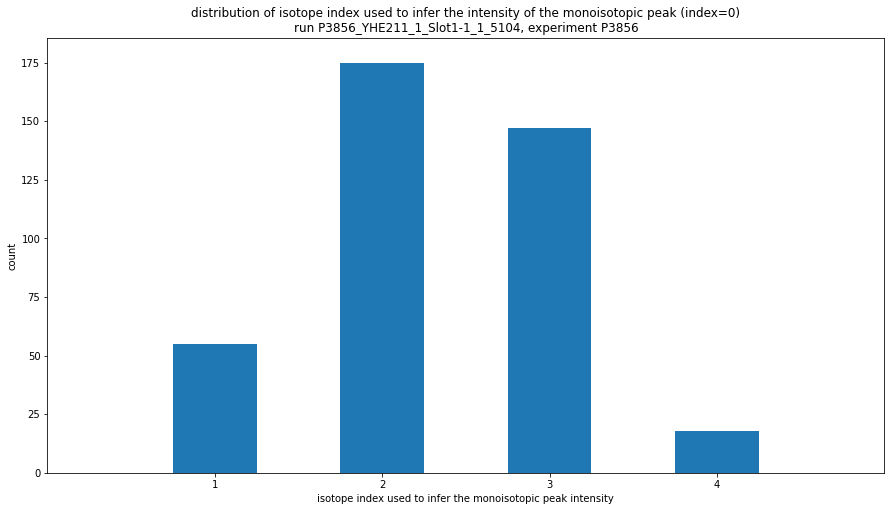

In [40]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

counts = np.bincount(isotope_idxs_df.isotope_idx_not_in_saturation)
ax1.bar(range(isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), counts, width=0.5, align='center')
ax1.set(xticks=range(1,isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), xlim=[0, isotope_idxs_df.isotope_idx_not_in_saturation.max()+1])

plt.xlabel('isotope index used to infer the monoisotopic peak intensity')
plt.ylabel('count')
plt.title('distribution of isotope index used to infer the intensity of the monoisotopic peak (index=0)\nrun {}, experiment {}'.format(RUN_NAME, EXPERIMENT_NAME))

plt.show()